In [98]:
%matplotlib inline
import pandas as pd

In [106]:
class VortexaSDK:
    '''
    This is a mock Vortexa SDK.
    '''
    
    def __init__(self):
        self.cms = pd.read_csv('/Users/kit/Downloads/movements2.csv', encoding='latin-1')
        self.cms['DESTINATION DISCHARGED'] = pd.to_datetime(self.cms['DESTINATION DISCHARGED'])
        self.cms['ORIGIN LOADED'] = pd.to_datetime(self.cms['ORIGIN LOADED'])
    
    def read_cargo_movements(self, vessel=None, destination_port=None, origin=None):
        all_cms = self.cms
        
        if vessel != None:
            all_cms = all_cms[all_cms['PRIMARY VESSEL'] == vessel]
            
        if destination_port != None:
            all_cms = all_cms[all_cms['DESTINATION PORT'] == destination_port]
            
        return all_cms

First we instantiate our SDK, using our vortexa API key stored as an environment var by default

In [107]:
v = VortexaSDK()

Let's see what's been discharging in Houston recently

In [110]:
v.read_cargo_movements(destination_port='Houston, TX [US]').head(4)

,PRIMARY VESSEL,PRIMARY IMO,PRIMARY DWT (t),PRIMARY CAPACITY (cbm),PRIMARY CLASS,VOYAGE TYPE,STATUS,CHARTERER,SECONDARY VESSEL,SECONDARY DWT (t),...,PRODUCT GRADE,QUANTITY (bbl),DESTINATION TERMINAL,DESTINATION PORT,DESTINATION COUNTRY,DESTINATION TRADING REGION,DESTINATION DISCHARGED,DESTINATION DISCHARGED WEEK,DESTINATION DISCHARGED MONTH,Unnamed: 31
3,EAGLE BARCELONA,9795048.0,113327,126772,Aframax / LR2,Single,Loading,NaN,NaN,NaN,...,VGO,544005,NaN,"Houston, TX [US]",United States,PADD 3 (US Gulf Coast),2019-11-13,11 Nov 2019,Nov 19,NaN
40,ANGISTRI,9176773.0,76002,75588,Panamax / LR1,Single,In Transit,REPSOL,NaN,NaN,...,Low Sulphur,353595,NaN,"Houston, TX [US]",United States,PADD 3 (US Gulf Coast),2019-11-12,11 Nov 2019,Nov 19,NaN
500,CHEMTRANS MOON,9270488.0,72365,78148,Panamax / LR1,Single,Discharged,NaN,NaN,NaN,...,High Sulphur,420646,Bostco Llc (Kinder Morgan Terminal),"Houston, TX [US]",United States,PADD 3 (US Gulf Coast),2019-10-25,21 Oct 2019,Oct 19,NaN
511,GRIMSTAD,9336402.0,105786,119063,Aframax / LR2,Single,Discharging,LYONDELL,NaN,NaN,...,Maya,568631,Houston Enterprise Terminal,"Houston, TX [US]",United States,PADD 3 (US Gulf Coast),2019-10-26,21 Oct 2019,Oct 19,NaN


In [112]:
v.read_cargo_movements()['PRIMARY CLASS'].unique()

array(['Aframax / LR2', 'Panamax / LR1', 'VLCC+', 'Suezmax',
       'Handymax / MR', 'General Purpose', 'Handysize'], dtype=object)

Let's do something more interesting.



## How often do vessels switch between Clean and Dirty?

In [113]:
# Load all cargo movements
df = v.read_cargo_movements()

In [114]:
# We're only interested in vessel, cargo (product group), and loading timestamp

df = df[['PRIMARY VESSEL', 'PRODUCT GROUP', 'ORIGIN LOADED']]\
    .sort_values(by='ORIGIN LOADED')\
    .copy(deep=True)

In [115]:
vessel_to_cargo = {}
swap_indexes = []

for index, cm in df.iterrows():
    vessel = cm['PRIMARY VESSEL']
    current_cargo = cm['PRODUCT GROUP']
    previous_cargo = vessel_to_cargo.get(vessel, None)
    
    if previous_cargo is None:
        vessel_to_cargo[vessel] = current_cargo
        swap_indexes.append(index)
        
    elif previous_cargo == current_cargo:
        # No swap, carry on
        continue
    elif previous_cargo != current_cargo:
        # print("{} swaped from {} to {}".format(vessel, previous_cargo, current_cargo))
        swap_indexes.append(index)
        vessel_to_cargo[vessel] = current_cargo


In [116]:
# Let's group this by week of year
df['date'] = df['ORIGIN LOADED'].dt.date

In [117]:
swap_movements = df[df.index.isin(swap_indexes)]

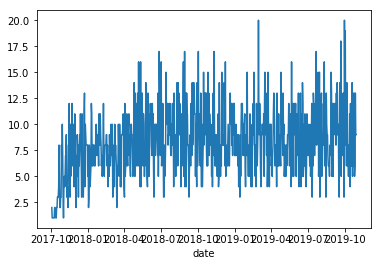

In [76]:
swap_movements.groupby(by='date').count()['PRIMARY VESSEL'].plot()

In [119]:
swaps_per_day = swap_movements.groupby(by='date').count()['PRIMARY VESSEL']

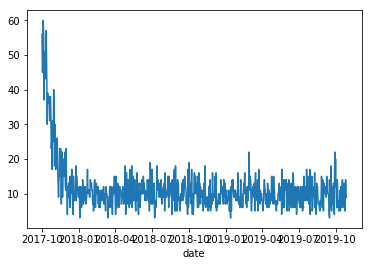

In [120]:
swaps_per_day.plot()

In [121]:
# It looks like a lot of these swaps are from out first loading. Let's look from 2018 H2 onwards

In [122]:
genuine_swaps = swaps_per_day[swaps_per_day.index > pd.to_datetime('2018-06-01').date()]

In [131]:
d = pd.DataFrame(genuine_swaps)

In [134]:
d['rolling'] = d['PRIMARY VESSEL'].rolling('7s')

ValueError: window must be an integer

In [130]:
pd.DataFrame(genuine_swaps)

,PRIMARY VESSEL
date,
2018-06-02,6
2018-06-03,9
2018-06-04,11
2018-06-05,10
2018-06-06,14
2018-06-07,13
2018-06-08,10
2018-06-09,10
2018-06-10,15


In [127]:
genuine_swaps.plot(figsize=(15, 15))

TypeError: Empty 'DataFrame': no numeric data to plot

In [45]:
df['duration'] = df.apply(lambda x: x['DESTINATION DISCHARGED'] - x['ORIGIN LOADED'], axis=1)

KeyError: ('DESTINATION DISCHARGED', 'occurred at index 47244')

In [69]:
df['duration'].fillna(0, inplace=True)

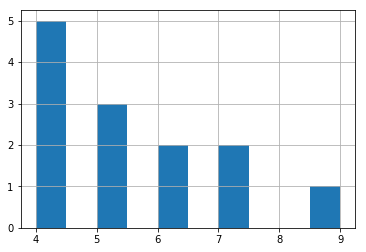

In [74]:
-df['duration'].map(lambda x: x.days).hist()

- (efford, reward) / 10
- (5, 2) Speed at which VLCC Ballast tankers are moving ASIA -> US GULF
- (2, 1) Speed of laden vessels from US to Asia
- (3, 2) US Crude exports VIA panama / VIA suez vs VIA cape
- (1, ?) No. of VLCCs loading form US gulf / US guls sts areas and heading to asia (by month)
- (3, ?) No. of tankrs visiting a shipyard (which shipyard) by month (could be fitting scrubbers, or maintenance)
- (7, ?) Average time spend in port for ballast tankers visiting US Gulf (how quickyl is logistical infrastructure improving, allowing for higher crude exports from US Gulf)
- (6, ?) Frequency of tankers changing clean -> dirty and dirty -> clean
- (5, ?) No. of new tankers leaving shipyards per month, by vesselclass
- (10,?) Amount of times tanker has switched AIS off
- (8, ?) Vessel owner having many tankers moved out of or in to a region
- (8, ?) Vessel owner putting their tanker into shipyards (per month, per vessel owner), (so you know potentially who has put om the biggest orders for scrubbers) 